# Makemore part 5

Implement the Wavenet architecture as described by Karpathy in the video.

## Helper functions to create datasets

In [1]:
with open('names.txt', 'r') as file:
    names = file.read().splitlines()

len(names)

32033

In [3]:
import random

random.seed(42)
# Shuffle the names to ensure random distribution
random.shuffle(names)

# Calculate split indices
train_split = int(0.8 * len(names))
val_split = int(0.9 * len(names))

# Split the names
train_names = names[:train_split]
val_names = names[train_split:val_split]
test_names = names[val_split:]

print(f"Train set size: {len(train_names)}")
print(f"Validation set size: {len(val_names)}")
print(f"Test set size: {len(test_names)}")

Train set size: 25626
Validation set size: 3203
Test set size: 3204


In [4]:
chars = sorted(list(set("".join(name for name in names))))
len(chars)

26

In [5]:
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, ch in enumerate(chars):
    stoi[ch] = i + 1
    itos[i + 1] = ch

len(stoi), len(itos)

(27, 27)

In [13]:
import torch

def create_dataset(names, block_size):
    X, y = [], []

    for name in names:
        name = ['.'] * block_size + list(name) + ['.']

        for i, ch in enumerate(name[block_size:]):
            input_seq = name[i:i+block_size]
            output_seq = ch
            X.append([stoi[c] for c in input_seq])
            y.append(stoi[output_seq])

    X = torch.LongTensor(X)
    y = torch.LongTensor(y)

    return X, y

## Reimplement MLP and check on the performance if the window size improves

In [143]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn((fan_in, fan_out), dtype=torch.float32) * 1 / ((fan_in)**0.50)
        self.bias = bias
        if self.bias:
            self.b = torch.zeros(fan_out). float()
        self.training = True

    def __call__(self, x):
        self.out = x @ self.W
        if self.bias:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([self.b] if self.bias else [])
    
class BatchNorm1d:
    def __init__(self, n_dims, momentum=0.10, epsilon=1e-5):
        self.momentum = momentum
        self.epsilon = epsilon
        self.training = True

        # learnable params
        self.bngain = torch.ones(n_dims).float()
        self.bnbias = torch.zeros(n_dims).float()

        # running stats
        self.running_mean = torch.zeros(n_dims).float()
        self.running_var = torch.ones(n_dims).float()

    def __call__(self, x):
        if self.training:
            bnmean = x.mean(dim=0, keepdim=True)
            bnvar = x.var(dim=0, keepdim=True)
        else:
            bnmean = self.running_mean
            bnvar = self.running_var

        bnraw = (x - bnmean) / torch.sqrt(bnvar + self.epsilon)
        self.out = self.bngain * bnraw + self.bnbias

        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * bnmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * bnvar + (1 - self.momentum) * self.running_var

        return self.out

    def parameters(self):
        return [self.bngain, self.bnbias]
    
class Tanh:
    def __init__(self):
        self.training = True

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.C = torch.randn((num_embeddings, embedding_dim), dtype=torch.float32)
        self.training = True

    def __call__(self, ix):
        self.out = self.C[ix]
        return self.out
    
    def parameters(self):
        return [self.C]
    
class Flatten:
    def __init__(self):
        self.training = True
        
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __getitem__(self, idx):
        return self.layers[idx]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def train(self):
        for layer in self.layers:
            layer.training = True

        for p in self.parameters():
            p.requires_grad = True

    def eval(self):
        for layer in self.layers:
            layer.training = False

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def update_params(self, lr):
        with torch.no_grad():
            for p in self.parameters():
                p.data -= lr * p.grad
        
    def num_params(self):
        return sum([p.numel() for p in self.parameters()])

In [144]:
# define the model

torch.manual_seed(42)

vocab_size = len(stoi)
emb_dim = 10
block_size = 8
hidden_dim = 300

model = Sequential(
    [
        Embedding(vocab_size, emb_dim), Flatten(),
        Linear(block_size * emb_dim, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# make last layer less confident
model[-1].W.data *= 0.10

model.train()

print(f"Number of params: {model.num_params()}")

Number of params: 32997


In [145]:
# Create datasets for training, validation, and test sets

X_train, y_train = create_dataset(train_names, block_size)
X_val, y_val = create_dataset(val_names, block_size)
X_test, y_test = create_dataset(test_names, block_size)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: torch.Size([182566, 8]), y_train shape: torch.Size([182566])
X_val shape: torch.Size([22778, 8]), y_val shape: torch.Size([22778])
X_test shape: torch.Size([22802, 8]), y_test shape: torch.Size([22802])


In [146]:
# training loop

n_iters = 200000
batch_size = 128
lr_scheduler = lambda i: 0.10 if i<100000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = model(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    model.zero_grad()
    loss.backward()
    model.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/200000 --> 3.3092041015625
Step 10000/200000 --> 2.069713830947876
Step 20000/200000 --> 1.9865787029266357
Step 30000/200000 --> 2.1107020378112793
Step 40000/200000 --> 2.0885727405548096
Step 50000/200000 --> 1.8363980054855347
Step 60000/200000 --> 2.0119614601135254
Step 70000/200000 --> 1.8665086030960083
Step 80000/200000 --> 1.9492698907852173
Step 90000/200000 --> 1.879730224609375
Step 100000/200000 --> 1.7022539377212524
Step 110000/200000 --> 1.766777515411377
Step 120000/200000 --> 1.87026846408844
Step 130000/200000 --> 1.8936936855316162
Step 140000/200000 --> 1.8926624059677124
Step 150000/200000 --> 1.8731715679168701
Step 160000/200000 --> 1.7949687242507935
Step 170000/200000 --> 1.7979928255081177
Step 180000/200000 --> 1.7712557315826416
Step 190000/200000 --> 1.8167493343353271


In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)

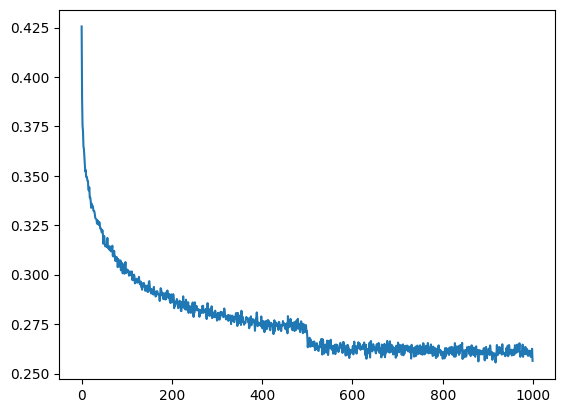

In [149]:
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [150]:
@torch.no_grad()
def compute_loss(model, X, y):
    logits = model(X)
    loss = torch.nn.functional.cross_entropy(logits, y)
    return loss.item()

In [151]:
model.eval()

In [152]:
train_loss = compute_loss(model, X_train, y_train)
val_loss = compute_loss(model, X_val, y_val)
test_loss = compute_loss(model, X_test, y_test)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")

Train Loss: 1.8002620935440063
Validation Loss: 2.044687509536743
Test Loss: 2.0318899154663086


## Implement WaveNet

The main idea WaveNet tries to solve is compressing the n-sized window into a single embedding. Instead, we itertively compress a bigram, 4-gram, 8-gram etc into hidden states and pass this to the next layers

In [206]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn((fan_in, fan_out), dtype=torch.float32) * 1 / ((fan_in)**0.50)
        self.bias = bias
        if self.bias:
            self.b = torch.zeros(fan_out). float()
        self.training = True

    def __call__(self, x):
        self.out = x @ self.W
        if self.bias:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([self.b] if self.bias else [])
    
class BatchNorm1d:
    def __init__(self, n_dims, momentum=0.10, epsilon=1e-5):
        self.momentum = momentum
        self.epsilon = epsilon
        self.training = True

        # learnable params
        self.bngain = torch.ones(n_dims).float()
        self.bnbias = torch.zeros(n_dims).float()

        # running stats
        self.running_mean = torch.zeros(n_dims).float()
        self.running_var = torch.ones(n_dims).float()

    def __call__(self, x):
        if x.ndim == 2:
            dim = 0
        else:
            dim = (0, 1)

        if self.training:
            bnmean = x.mean(dim=dim, keepdim=True)
            bnvar = x.var(dim=dim, keepdim=True)
        else:
            bnmean = self.running_mean
            bnvar = self.running_var

        bnraw = (x - bnmean) / torch.sqrt(bnvar + self.epsilon)
        self.out = self.bngain * bnraw + self.bnbias

        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * bnmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * bnvar + (1 - self.momentum) * self.running_var

        return self.out

    def parameters(self):
        return [self.bngain, self.bnbias]
    
class Tanh:
    def __init__(self):
        self.training = True

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.C = torch.randn((num_embeddings, embedding_dim), dtype=torch.float32)
        self.training = True

    def __call__(self, ix):
        self.out = self.C[ix]
        return self.out
    
    def parameters(self):
        return [self.C]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.training = True
        self.n = n
        
    def __call__(self, x):
        B, BS, E = x.shape
        self.out = x.view(B, BS//self.n, E * self.n).squeeze(1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __getitem__(self, idx):
        return self.layers[idx]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            # print(f"{layer.__class__.__name__:30s} | {x.shape}")

        self.out = x
        return self.out
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def train(self):
        for layer in self.layers:
            layer.training = True

        for p in self.parameters():
            p.requires_grad = True

    def eval(self):
        for layer in self.layers:
            layer.training = False

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def update_params(self, lr):
        with torch.no_grad():
            for p in self.parameters():
                p.data -= lr * p.grad
        
    def num_params(self):
        return sum([p.numel() for p in self.parameters()])

In [207]:
torch.manual_seed(42)

n_embd = 24
hidden_dim = 128
vocab_size = len(stoi)
block_size = 8

wavenet_model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# reduce confidence of the last layer
wavenet_model[-1].W.data *= 0.10

print(f"No. of parameters in the model: {wavenet_model.num_params()}")

No. of parameters in the model: 76579


In [208]:
wavenet_model.train()

In [209]:
# Create datasets for training, validation, and test sets

X_train, y_train = create_dataset(train_names, block_size)
X_val, y_val = create_dataset(val_names, block_size)
X_test, y_test = create_dataset(test_names, block_size)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: torch.Size([182566, 8]), y_train shape: torch.Size([182566])
X_val shape: torch.Size([22778, 8]), y_val shape: torch.Size([22778])
X_test shape: torch.Size([22802, 8]), y_test shape: torch.Size([22802])


In [210]:
# training loop

n_iters = 200000
batch_size = 32
lr_scheduler = lambda i: 0.10 if i<150000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = wavenet_model(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    wavenet_model.zero_grad()
    loss.backward()
    wavenet_model.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/200000 --> 3.2960853576660156
Step 10000/200000 --> 2.3484861850738525
Step 20000/200000 --> 2.2358133792877197
Step 30000/200000 --> 2.1079940795898438
Step 40000/200000 --> 1.742045283317566
Step 50000/200000 --> 2.134948253631592
Step 60000/200000 --> 1.9138941764831543
Step 70000/200000 --> 2.328836441040039
Step 80000/200000 --> 2.2221524715423584
Step 90000/200000 --> 1.6186294555664062
Step 100000/200000 --> 1.940788745880127
Step 110000/200000 --> 2.310986042022705
Step 120000/200000 --> 1.8017786741256714
Step 130000/200000 --> 2.464643955230713
Step 140000/200000 --> 1.5771366357803345
Step 150000/200000 --> 1.777746558189392
Step 160000/200000 --> 1.9989373683929443
Step 170000/200000 --> 1.809552550315857
Step 180000/200000 --> 1.9123164415359497
Step 190000/200000 --> 1.8970130681991577


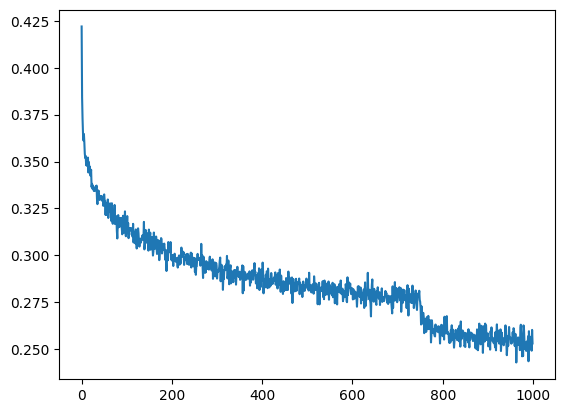

In [211]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [212]:
wavenet_model.eval()

In [213]:
train_loss = compute_loss(wavenet_model, X_train, y_train)
val_loss = compute_loss(wavenet_model, X_val, y_val)
test_loss = compute_loss(wavenet_model, X_test, y_test)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")

Train Loss: 1.7608709335327148
Validation Loss: 1.9923104047775269
Test Loss: 1.9885668754577637


## Sampling

In [223]:
torch.manual_seed(42)

wavenet_model.eval()

for i in range(20):
    curr_seq, curr_name = [0] * block_size, ""

    while True:
        inp = torch.LongTensor(curr_seq).view(1, -1)
        logits = wavenet_model(inp)
        probs = torch.softmax(logits, dim=1).squeeze()
        next_char_idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
        next_char = itos[next_char_idx]

        if next_char == '.':
            break
        curr_name += next_char
        curr_seq.append(next_char_idx)
        curr_seq = curr_seq[1:]

    print(curr_name)

anuki
natal
marian
daniella
silayah
artier
lucin
epicco
dennamis
kendrick
donovan
kriston
jaydeveria
aceela
jayan
tiernan
sotriniel
tourgan
abrin
annavi


# Performance tracker

## MLP with 33K params

Train Loss: 1.8002620935440063
Validation Loss: 2.044687509536743
Test Loss: 2.0318899154663086

## Wavenet with 33K params
Train Loss: 1.7828456163406372
Validation Loss: 2.0495035648345947
Test Loss: 2.040550947189331

## Wavenet with Andrej params
Train Loss: 1.7608709335327148
Validation Loss: 1.9923104047775269
Test Loss: 1.9885668754577637